# Flex Diffusers

This colab provides an extremely easy and simple way to enjoy text-to-image diffusion models, with lots of adjustable parameters to meet your requirements.

You can also upload an initial image to guide the model producing images with similar style.

Original Author: [huggingface](https://github.com/huggingface/diffusers)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/huggingface/diffusers

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/flex_diffusers.ipynb)

In [ ]:
#@title Setup

!pip install transformers gradio scipy ftfy "ipywidgets>=7,<8" datasets diffusers

In [ ]:
#@title Setup Models
import torch
from diffusers import (
  StableDiffusionPipeline,
  StableDiffusionImg2ImgPipeline,
  DDIMScheduler,
  PNDMScheduler,
  LMSDiscreteScheduler,
)


model_id = "hakurei/waifu-diffusion"  #@param ["hakurei/waifu-diffusion", "CompVis/stable-diffusion-v1-4", "doohickey/trinart-waifu-diffusion-50-50", "sd-dreambooth-library/disco-diffusion-style"]
#@markdown More available models can be found [here](https://huggingface.co/models?library=diffusers&sort=downloads)

use_auth_token = False
if model_id == "CompVis/stable-diffusion-v1-4":
  from google.colab import output
  from huggingface_hub import notebook_login
  output.enable_custom_widget_manager()
  notebook_login()
  use_auth_token = True

revision = 'fp16'
if model_id in {
  'doohickey/trinart-waifu-diffusion-50-50',
  'sd-dreambooth-library/disco-diffusion-style',
}:
  revision = None

torch_device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(
  model_id,
  revision=revision,
  torch_dtype=torch.float16,
  use_auth_token=use_auth_token,
)
pipe.to(torch_device)

uploaded_init_image = False
prev_is_img2img = False

def get_pipe(is_img2img=False):
  global prev_is_img2img, pipe, revision
  if prev_is_img2img == is_img2img:
    return pipe

  torch.cuda.empty_cache()
  if is_img2img:
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
      model_id,
      revision=revision,
      torch_dtype=torch.float16,
      use_auth_token=use_auth_token,
    )
    prev_is_img2img = True
  else:
    pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      revision=revision,
      torch_dtype=torch.float16,
      use_auth_token=use_auth_token,
    )
    prev_is_img2img = False
  pipe.to("cuda")
  return pipe

# Setup scheduler
num_inference_steps = 80
scheduler = PNDMScheduler()
scheduler.set_timesteps(num_inference_steps)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

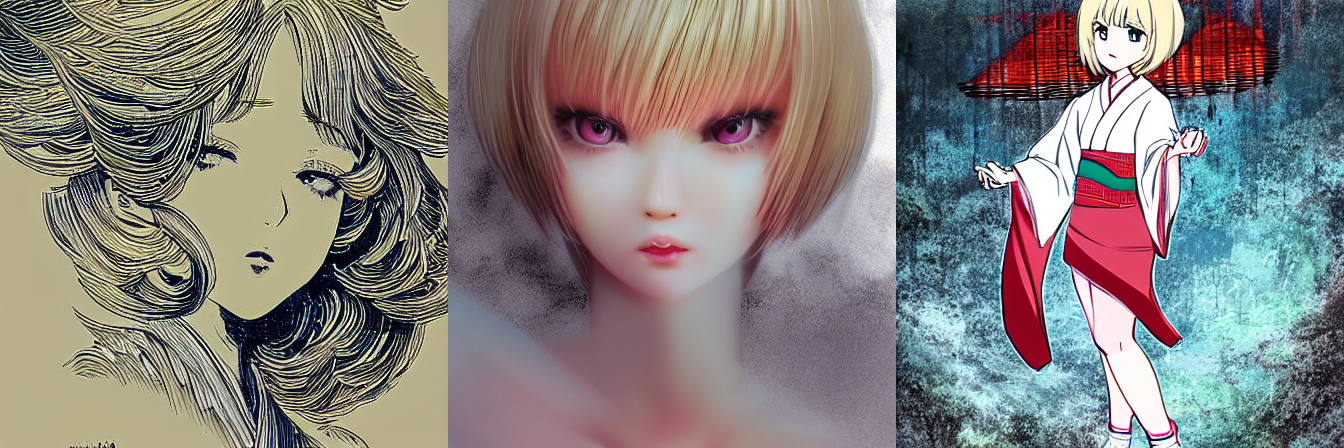

In [30]:
#@title Run

from google.colab import files
from IPython.display import display
from torch import autocast
from PIL import Image


prompt = "Young beautiful japanese girl, full body portrait short blond hair, beautiful face, modern girl, hyperdetailed, highly detailed"  #@param {type: "string"}
num_samples = 3  #@param {type: "integer"}
width = 448 #@param {type:"slider", min:448, max:640, step:64}
height = 448  #@param {type:"slider", min:448, max:640, step:64}
diffusion_steps = 70  #@param {type: "integer"}
guidance_scale = 6  #@param {type: "slider", min:0, max:20, step:0.1}
use_init_image = True #@param {type:"boolean"}
use_existing_init_image = True  #@param {type: "boolean"}


if use_init_image:
  if not (use_existing_init_image and uploaded_init_image):
    ff = files.upload()
    filename = list(ff.keys())[0]
    init_image = Image.open(filename)
    init_image = init_image.resize((width, height)).convert('RGB')
    uploaded_init_image = True
  stength = 0.8
  pipe_kwargs = {
    'init_image': init_image,
    'strength': 0.8,
  }
else:
  pipe_kwargs = {
    'width': width,
    'height': height,
  }


def image_grid(imgs, rows=1, cols=3):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  
  for i, img in enumerate(imgs):
    grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid


def mock_safety_checker(clip_input, images, **kwargs):
  return images, [False for _ in range(len(images))]

pipe = get_pipe(use_init_image)
pipe.safety_checker = mock_safety_checker
with autocast("cuda"):
  images = pipe(
    prompt=[prompt] * num_samples,
    num_inference_steps=diffusion_steps,
    guidance_scale=guidance_scale,
    **pipe_kwargs,
  ).images

display(image_grid(images, cols=num_samples))